In [52]:
import os
import pandas as pd
import librosa
import numpy as np

# Function to extract features from audio file
def extract_features(audio_file_path):
    audio_data, _ = librosa.load(audio_file_path, sr=None, mono=True)
    max_amplitude = np.max(audio_data)
    min_amplitude = np.min(audio_data)
    mean_amplitude = np.mean(audio_data)
    std_amplitude = np.std(audio_data)

    fft_data = np.fft.fft(audio_data)
    n = len(audio_data)
    freq = np.fft.fftfreq(n)
    max_frequency = np.max(freq)
    min_frequency = np.min(freq)
    mean_frequency = np.mean(freq)
    std_frequency = np.std(freq)

    name = os.path.basename(audio_file_path)

    return [max_amplitude, min_amplitude, mean_amplitude, std_amplitude,
            max_frequency, min_frequency, mean_frequency, std_frequency, name]

# Create an empty DataFrame to store the data
columns = ['Max_Amplitude', 'Min_Amplitude', 'Mean_Amplitude', 'Std_Amplitude',
           'Max_Frequency', 'Min_Frequency', 'Mean_Frequency', 'Std_Frequency', 'Name']
df = pd.DataFrame(columns=columns)

directory = '/content/sample_data/MP3'

files = os.listdir(directory)

audio_files = [file for file in files if file.endswith('.mp3')]

for i, audio_file in enumerate(audio_files):
    full_audio_file_path = os.path.join(directory, audio_file)
    features = extract_features(full_audio_file_path)
    df.loc[i] = features
    #print("Processing:", audio_file)

df.to_csv('audio_database.csv')


In [53]:
from sklearn.ensemble import IsolationForest

df = pd.read_csv('audio_database.csv')
file_names = df['Name']
df = df.drop(columns=['Name'])

X = df.values

isolation_forest = IsolationForest(contamination = 0.3)
isolation_forest.fit(X)


outlier_preds = isolation_forest.predict(X)

# Add outlier predictions to the DataFrame
df['Outlier_Prediction'] = outlier_preds
df['Name'] = file_names

df.to_csv('audio_database_with_outliers.csv', index=False)

import os
import shutil

source_directory = '/content/sample_data/MP3'
destination_directory = '/content/sample_data/Anomaly_files'

if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Filter the DataFrame to get rows where 'Outlier_Prediction' is -1 (indicating an anomaly)
anomaly_df = df[df['Outlier_Prediction'] == -1]

# Iterate through the anomaly file names and copy them to the destination directory
i = 0
for file_name in anomaly_df['Name']:
    source_file_path = os.path.join(source_directory, file_name)
    destination_file_path = os.path.join(destination_directory, file_name)
    shutil.copyfile(source_file_path, destination_file_path)

    file_name_without_extension = os.path.splitext(os.path.basename(file_name))[0]
    chart_file = os.path.join(file_name_without_extension + ".png")


    source_file_path = os.path.join('/content/sample_data/Charts', chart_file)
    destination_file_path = os.path.join(destination_directory, chart_file)
    shutil.copyfile(source_file_path, destination_file_path)
    i += 1

print(i)

147


In [54]:
import os
import pandas as pd
import shutil

df = pd.read_csv('/content/sample_data/classificacao_anomalias.csv')

not_anomalies = df[df['Classe'] == 'Não anomalia']

source_directory_mp3 = '/content/sample_data/MP3'
source_directory_png = '/content/sample_data/Charts'
destination_directory = '/content/sample_data/Correct_files'

if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Iterate through the anomaly file names and copy them to the destination directory
i = 0
for file_name in not_anomalies['File Name']:
    source_file_path = os.path.join(source_directory_mp3, file_name)
    destination_file_path = os.path.join(destination_directory, file_name)
    shutil.copyfile(source_file_path, destination_file_path)

    file_name_without_extension = os.path.splitext(os.path.basename(file_name))[0]
    chart_file = os.path.join(file_name_without_extension + ".png")


    source_file_path = os.path.join(source_directory_png, chart_file)
    destination_file_path = os.path.join(destination_directory, chart_file)
    shutil.copyfile(source_file_path, destination_file_path)
    i += 1

print(i)

224


In [56]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('audio_database.csv')

tutor = pd.read_csv('/content/sample_data/classificacao_anomalias.csv')
tutor = tutor[['File Name', 'Label']]
tutor['Label'] = tutor['Label'].apply(lambda x: 1 if x == 0 else 0)
tutor.set_index('File Name',inplace=True)

display(tutor['Label'].value_counts())
tutor.head()

merged_df = pd.merge(df, tutor, left_on='Name', right_index=True, how='left')

merged_df.dropna(inplace=True)

print("Merged dataframe shape:", merged_df.shape)
print(merged_df.head())

X = merged_df.drop(columns=['Label', 'Name']).values
y = merged_df['Label'].values
print("X shape:", X.shape)
print("y shape:", y.shape)


max_depth = 5
classifiers = [
    DecisionTreeClassifier(random_state=42,max_depth=max_depth),
    ExtraTreeClassifier(random_state=42,max_depth=max_depth),
    RandomForestClassifier(random_state=42,max_depth=max_depth),
    ExtraTreesClassifier(random_state=42,max_depth=max_depth),
    GradientBoostingClassifier(random_state=42,max_depth=max_depth),
    AdaBoostClassifier(random_state=42),
    HistGradientBoostingClassifier(random_state=42,max_depth=max_depth),
    LogisticRegression(random_state=42),
]

results = []
for cls in tqdm(classifiers):
  res = cross_validate(cls, X, y, cv = 5, scoring='f1')
  results.append(
      {'method': cls.__class__.__name__,
       'f1': res['test_score'].mean(),
       'time': res['fit_time'].mean(),
       }
  )

warnings.filterwarnings('default')
df_res = pd.DataFrame(results)
df_res.sort_values('f1', ascending = False)



Label
0    266
1    224
Name: count, dtype: int64

Merged dataframe shape: (490, 11)
   Unnamed: 0  Max_Amplitude  Min_Amplitude  Mean_Amplitude  Std_Amplitude  \
0           0       0.610421      -0.448508       -0.000006       0.016729   
1           1       0.447103      -0.469480       -0.000004       0.013506   
2           2       1.232991      -1.184630        0.000424       0.278398   
3           3       0.607398      -0.510997       -0.000001       0.040038   
4           4       0.160122      -0.217963       -0.000032       0.016777   

   Max_Frequency  Min_Frequency  Mean_Frequency  Std_Frequency        Name  \
0       0.499998           -0.5   -7.602666e-07       0.288675  a00064.mp3   
1       0.499999           -0.5   -2.591297e-07       0.288675  a00313.mp3   
2       0.499999           -0.5   -4.535032e-07       0.288675  a00331.mp3   
3       0.499997           -0.5   -1.335014e-06       0.288675  a00024.mp3   
4       0.499998           -0.5   -1.166219e-06       0.288675  a00366.mp3   

   Label  
0      0  
1     

100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


,method,f1,time
3,ExtraTreesClassifier,0.630681,0.119606
2,RandomForestClassifier,0.625570,0.232048
4,GradientBoostingClassifier,0.608311,0.260549
5,AdaBoostClassifier,0.607808,0.105905
0,DecisionTreeClassifier,0.591276,0.003452
6,HistGradientBoostingClassifier,0.581766,0.134797
7,LogisticRegression,0.402174,0.011893
1,ExtraTreeClassifier,0.228604,0.001948


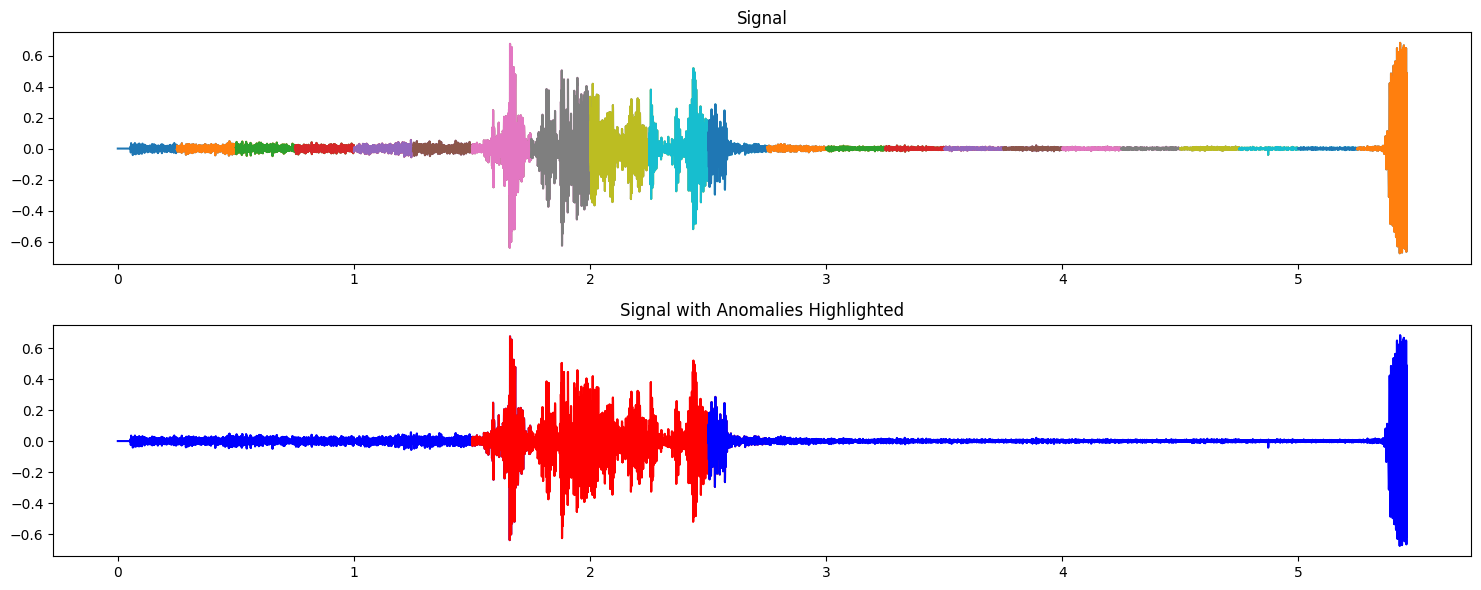

In [58]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Load audio file
y, sr = librosa.load('/content/sample_data/MP3/a00001.mp3')
time = np.arange(len(y)) / sr

# Set window and step sizes
window_size = int(0.5 * sr)
step_size = int(0.25 * sr)

# Extract signal segments
segments = [(time[i:i+window_size], y[i:i+window_size]) for i in range(0, len(y), step_size)]

# Calculate maximum segment length
max_seg_length = 0
for segment in segments:
    if len(segment[1]) > max_seg_length:
        max_seg_length = len(segment[1])

# Plot signal segments
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].set_title('Signal')
for t, signal in segments:
    ax[0].plot(t, signal)

# Fit Isolation Forest model
X = [np.pad(segment[1], (0, max_seg_length - len(segment[1])), mode='constant') for segment in segments]
clf = IsolationForest(contamination=0.15)
clf.fit(X)

# Predict anomalies
anomalies = clf.predict(X)
anomalies = (anomalies == -1)

# Highlight anomalies in the plot
ax[1].set_title('Signal with Anomalies Highlighted')
for i, (t, signal) in enumerate(segments):
    ax[1].plot(t, signal, color='red' if anomalies[i] else 'blue')

plt.tight_layout()
plt.show()
